<a href="https://colab.research.google.com/github/tleitch/BDML/blob/main/linear_models_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
pd.options.mode.chained_assignment = None  # default='warn'
!pip install mip
!pip install plotnine
from mip import Model, xsum, maximize, BINARY

     |████████████████████████████████| 48.0MB 84kB/s 


# Confounding 

Previously, we noted a strong relationship between Runs and BB. If we find the regression line for predicting runs from bases on balls, we a get slope of:

In [ ]:
%%R
library(tidyverse)
library(Lahman)
get_slope <- function(x, y) cor(x, y) * sd(y) / sd(x)

bb_slope <- Teams %>% 
  filter(yearID %in% 1961:2001 ) %>% 
  mutate(BB_per_game = BB/G, R_per_game = R/G) %>% 
  summarize(slope = get_slope(BB_per_game, R_per_game))

bb_slope 

So does this mean that if we go and hire low salary players with many BB, and who therefore increase the number of walks per game by 2, our team will score **r round(bb_slope*2, 1)** more runs per game? 

We are again reminded that association is not causation. The data does provide strong evidence that a team with two more BB per game than the average team, scores **r round(bb_slope*2, 1)** runs per game. But this does not mean that BB are the cause. 

Note that if we compute the regression line slope for singles we get:

In [ ]:
%%R
singles_slope <- Teams %>% 
  filter(yearID %in% 1961:2001 ) %>%
  mutate(Singles_per_game = (H-HR-X2B-X3B)/G, R_per_game = R/G) %>%
  summarize(slope = get_slope(Singles_per_game, R_per_game))

singles_slope 

which is a lower value than what we obtain for BB.

Also, notice that a single gets you to first base just like a BB. Those that know about baseball will tell you that with a single, runners on base have a better chance of scoring than with a BB. So how can BB be more predictive of runs? The reason this happen is because of confounding. Here we show the correlation between HR, BB, and singles:

In [ ]:
%%R
Teams %>% 
  filter(yearID %in% 1961:2001 ) %>% 
  mutate(Singles = (H-HR-X2B-X3B)/G, BB = BB/G, HR = HR/G) %>%  
  summarize(cor(BB, HR), cor(Singles, HR), cor(BB, Singles))

It turns out that pitchers, afraid of HRs, will sometimes avoid throwing strikes to HR hitters. As a result, HR hitters tend to have more BBs and a team with many HRs will also have more BBs. Although it may appear that BBs cause runs, it is actually the HRs that cause most of these runs. We say that BBs are _confounded_ with HRs. Nonetheless, could it be that BBs still help? To find out, we somehow have to adjust for the HR effect. Regression can help with this as well.

### Understanding confounding through stratification 

A first approach is to keep HRs fixed at a certain value and then examine the relationship between BB and runs. As we did when we stratified fathers by rounding to the closest inch, here we can stratify HR per game to the closest ten. We filter out the strata with few points to avoid highly variable estimates:

In [ ]:
%%R
dat <- Teams %>% filter(yearID %in% 1961:2001) %>%
  mutate(HR_strata = round(HR/G, 1), 
         BB_per_game = BB / G,
         R_per_game = R / G) %>%
  filter(HR_strata >= 0.4 & HR_strata <=1.2) 

and then make a scatterplot for each strata:

In [ ]:
%%R
dat %>% 
  ggplot(aes(BB_per_game, R_per_game)) +  
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm") +
  facet_wrap( ~ HR_strata) 

Remember that the regression slope for predicting runs with BB was **r round(bb_slope, 1)**. Once we stratify by HR, these slopes are substantially reduced:

In [ ]:
%%R
dat %>%  
  group_by(HR_strata) %>%
  summarize(slope = get_slope(BB_per_game, R_per_game))

The slopes are reduced, but they are not 0, which indicates that BBs are helpful for producing runs, just not as much as previously thought.
In fact, the values above are closer to the slope we obtained from singles, **r round(singles_slope, 2)**, which is more consistent with our intuition. Since both singles and BB get us to first base, they should have about the same predictive power.

Although our understanding of the application tells us that HR cause BB but not the other way around, we can still check if stratifying by BB makes the effect of BB go down. To do this, we use the same code except that we swap HR and BBs to get this plot:



In this case, the slopes do not change much from the original:

In [ ]:
%%R
dat %>% group_by(BB_strata) %>%
   summarize(slope = get_slope(HR_per_game, R_per_game))

They are reduced a bit, which is consistent with the fact that BB do in fact cause some runs.

In [ ]:
%%R
hr_slope <- Teams %>% 
  filter(yearID %in% 1961:2001 ) %>% 
  mutate(HR_per_game = HR/G, R_per_game = R/G) %>% 
  summarize(slope = get_slope(HR_per_game, R_per_game))

hr_slope

Regardless, it seems that if we stratify by HR, we have bivariate distributions for runs versus BB. Similarly, if we stratify by BB, we have approximate bivariate normal distributions for HR versus runs. 

###  Multivariate regression

It is somewhat complex to be computing regression lines for each strata. We are essentially fitting models like this:

$$
\mbox{E}[R \mid BB = x_1, \, HR = x_2] = \beta_0 + \beta_1(x_2) x_1 + \beta_2(x_1) x_2
$$

with the slopes for $x_1$ changing for different values of $x_2$ and vice versa. But is there an easier approach?

If we take random variability into account, the slopes in the strata don't appear to change much. If these slopes are in fact the same, this implies that $\beta_1(x_2)$ and $\beta_2(x_1)$ are constants. This in turn implies that the expectation of runs conditioned on HR and BB can be written like this:

$$
\mbox{E}[R \mid BB = x_1, \, HR = x_2] = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

This model suggests that if the number of HR is fixed at $x_2$, we observe a linear relationship between runs and BB with an intercept of $\beta_0 + \beta_2 x_2$. Our exploratory data analysis suggested this. The model also suggests that as the number of HR grows, the intercept growth is linear as well and determined by $\beta_1 x_1$. 

In this analysis, referred to as _multivariate regression_, you will often hear people say that the BB slope $\beta_1$ is _adjusted_ for the HR effect. If the model is correct then confounding has been accounted for. But how do we estimate $\beta_1$ and $\beta_2$ from the data? For this, we learn about linear models and least squares estimates.

## Least squares estimates {#lse}

We have described how if data is bivariate normal then the conditional expectations follow the regression line. The fact that the conditional expectation is a line is not an extra assumption but rather a derived result. However, in practice it is common to explicitly write down a model that describes the relationship between two or more variables using a _linear model_. 

We note that "linear" here does not refer to lines exclusively, but rather to the fact that the conditional expectation is a linear combination of known quantities. In mathematics, when we multiply each variable by a constant and then add them together, we say we formed a linear combination of the variables. For example, $3x - 4y + 5z$ is a linear combination of $x$, $y$, and $z$. We can also add a constant so $2 + 3x - 4y + 5z$ is also linear combination of $x$, $y$, and $z$. 

So $\beta_0 + \beta_1 x_1 + \beta_2 x_2$, is a linear combination of $x_1$ and $x_2$. 
The simplest linear model is a constant $\beta_0$; the second simplest is a line $\beta_0 + \beta_1 x$. If we were to specify a linear model for Galton's data, we would denote the $N$ observed father heights with $x_1, \dots, x_n$, then we model the $N$ son heights we are trying to predict with: 

$$ 
Y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, \, i=1,\dots,N. 
$$

Here $x_i$ is the father's height, which is fixed (not random) due to the conditioning, and $Y_i$ is the random son's height that we want to predict. We further assume that $\varepsilon_i$ are independent from each other, have expected value 0 and the standard deviation, call it $\sigma$, does not depend on $i$. 

In the above model, we know the $x_i$, but to have a useful model for prediction, we need $\beta_0$ and $\beta_1$. We estimate these from the data. Once we do this, we can predict son's heights for any father's height $x$. We show how to do this in the next section.

Note that if we further assume that the $\varepsilon$ is normally distributed, then this model is exactly the same one we derived earlier by assuming bivariate normal data. A somewhat nuanced difference is that in the first approach we assumed the data was bivariate normal and that the linear model was derived, not assumed. In practice, linear models are just assumed without necessarily assuming normality: the distribution of the $\varepsilon$s is not specified.  Nevertheless, if your data is bivariate normal, the above linear model holds. If your data is not bivariate normal, then you will need to have other ways of justifying the model.

### Interpreting linear models

One reason linear models are popular is that they are interpretable. In the case of Galton's data, we can interpret the data like this: due to inherited genes, the son's height prediction grows by $\beta_1$ for each inch we increase the father's height $x$. Because not all sons with fathers of height $x$ are of equal height, we need the term $\varepsilon$, which explains the remaining variability. This remaining variability includes the mother's genetic effect, environmental factors, and other biological randomness. 

Given how we wrote the model above, the intercept $\beta_0$ is not very interpretable as it is the predicted height of a son with a father with no height. Due to regression to the mean, the prediction will usually be a bit larger than 0. To make the slope parameter more interpretable, we can rewrite the model slightly as:

$$ 
Y_i = \beta_0 + \beta_1 (x_i - \bar{x}) + \varepsilon_i, \, i=1,\dots,N 
$$


with $\bar{x} = 1/N \sum_{i=1}^N x_i$ the average of the $x$. In this case $\beta_0$ represents the height when $x_i = \bar{x}$, which is the height of the son of an average father.

### Least Squares Estimates (LSE)

For linear models to be useful, we have to estimate the unknown $\beta$s. The standard approach in science is to find the values that minimize the distance of the fitted model to the data. The following is called the least squares (LS) equation and we will see it often in this chapter. For Galton's data, we would write:

$$ 
RSS = \sum_{i=1}^n \left\{  y_i - \left(\beta_0 + \beta_1 x_i \right)\right\}^2 
$$

This quantity is called the residual sum of squares (RSS). Once we find the values that minimize the RSS, we will call the values the least squares estimates (LSE) and denote them with $\hat{\beta}_0$ and $\hat{\beta}_1$. Let's demonstrate this with the previously defined dataset:

In [ ]:
%%R
library(HistData)
data("GaltonFamilies")
set.seed(1983)
galton_heights <- GaltonFamilies %>%
  filter(gender == "male") %>%
  group_by(family) %>%
  sample_n(1) %>%
  ungroup() %>%
  select(father, childHeight) %>%
  rename(son = childHeight)

Let's write a function that computes the RSS for any pair of values $\beta_0$ and $\beta_1$.

In [ ]:
%%R
rss <- function(beta0, beta1, data){
  resid <- galton_heights$son - (beta0+beta1*galton_heights$father)
  return(sum(resid^2))
}

So for any pair of values, we get an RSS. Here is a plot of the RSS as a function of $\beta_1$ when we keep the $\beta_0$ fixed at 25.

In [ ]:
%%R
beta1 = seq(0, 1, len=nrow(galton_heights))
results <- data.frame(beta1 = beta1,
                      rss = sapply(beta1, rss, beta0 = 25))
results %>% ggplot(aes(beta1, rss)) + geom_line() + 
  geom_line(aes(beta1, rss))

We can see a clear minimum for $\beta_1$ at around 0.65. However, this minimum for $\beta_1$ is for when $\beta_0 = 25$, a value we arbitrarily picked. We don't know if  (25, 0.65) is the pair that minimizes the equation across all possible pairs. 

Trial and error is not going to work in this case. We could search for a minimum within a fine grid of $\beta_0$ and $\beta_1$ values, but this is unnecessarily time-consuming since we can use calculus: take the partial derivatives, set them to 0 and solve for $\beta_1$ and $\beta_2$. Of course, if we have many parameters, these equations can get rather complex. But there are functions in R that do these calculations for us. We will learn these next. To learn the mathematics behind this, you can consult a book on linear models. 

### The `lm` function

In R, we can obtain the least squares estimates using the `lm` function. To fit the model:

$$
Y_i = \beta_0 + \beta_1 x_i + \varepsilon_i
$$

with $Y_i$ the son's height and $x_i$ the father's height, we can use this code to obtain the least squares estimates.

In [ ]:
%%R
fit <- lm(son ~ father, data = galton_heights)
fit$coef

The most common way we use `lm` is by using the character `~` to let `lm` know which is the variable we are predicting (left of `~`) and which we are using to predict (right of `~`). The intercept is added automatically to the model that will be fit. 

The object `fit` includes more information about the fit. We can use the function `summary` to extract more of this information (not shown):

In [ ]:
%%R
summary(fit)

To understand some of the information included in this summary we need to remember that the LSE are random variables. Mathematical statistics gives us some ideas of the distribution of these random variables


### LSE are random variables 

The LSE is derived from the data $y_1,\dots,y_N$, which are a realization of random variables $Y_1, \dots, Y_N$.  This implies that our estimates are random variables. To see this, we can run a Monte Carlo simulation in which we assume the son and father height data defines a population, take a random sample of size $N=50$, and compute the regression slope coefficient for each one:

In [ ]:
%%R
B <- 1000
N <- 50
lse <- replicate(B, {
  sample_n(galton_heights, N, replace = TRUE) %>% 
    lm(son ~ father, data = .) %>% 
    .$coef 
})
lse <- data.frame(beta_0 = lse[1,], beta_1 = lse[2,]) 

We can see the variability of the estimates by plotting their distributions:



The reason these look normal is because the central limit theorem applies here as well: for large enough $N$, the least squares estimates will be approximately normal with expected value $\beta_0$ and $\beta_1$, respectively. The standard errors are a bit complicated to compute, but mathematical theory does allow us to compute them and they are included in the summary provided by the `lm` function. Here it is for one of our simulated data sets:

In [ ]:
%%R
 sample_n(galton_heights, N, replace = TRUE) %>% 
  lm(son ~ father, data = .) %>% 
  summary %>% .$coef

You can see that the standard errors estimates reported by the `summary` are close to the standard errors from the simulation:

In [ ]:
%%R
lse %>% summarize(se_0 = sd(beta_0), se_1 = sd(beta_1))

The `summary` function also reports t-statistics (`t value`) and p-values (`Pr(>|t|)`). The t-statistic is not actually based on the central limit theorem but rather on the assumption that the $\varepsilon$s follow a normal distribution. Under this assumption, mathematical theory tells us that the LSE divided by their standard error, $\hat{\beta}_0 / \hat{\mbox{SE}}(\hat{\beta}_0 )$ and $\hat{\beta}_1 / \hat{\mbox{SE}}(\hat{\beta}_1 )$, follow a t-distribution with $N-p$ degrees of freedom, with $p$ the number of parameters in our model. In the case of height $p=2$, the two p-values are testing the null hypothesis that $\beta_0 = 0$ and $\beta_1=0$, respectively. 

Remember that, as we described in Section \@ref(t-dist) for large enough $N$, the CLT works and the t-distribution becomes almost the same as the normal distribution. Also, notice that we can construct confidence intervals, but we will soon learn about __broom__, an add-on package that makes this easy.

Although we do not show examples in this book, hypothesis testing with regression models is commonly used in epidemiology and economics to make statements such as "the effect of A on B was statistically significant after adjusting for X, Y, and Z". However, several assumptions have to hold for these statements to be true. 


### Predicted values are random variables 

Once we fit our model, we can obtain prediction of $Y$ by plugging in the estimates into the regression model. For example, if the father's height is $x$, then our prediction $\hat{Y}$ for the son's height will be:

$$\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 x$$

When we plot $\hat{Y}$ versus $x$, we see the regression line.

Keep in mind that the prediction $\hat{Y}$ is also a random variable and mathematical theory tells us what the standard errors are. If we assume the errors are normal, or have a large enough sample size, we can use theory to construct confidence intervals as well. In fact, the __ggplot2__ layer `geom_smooth(method = "lm")` that we previously used plots $\hat{Y}$ and surrounds it by confidence intervals:

In [ ]:
%%R
galton_heights %>% ggplot(aes(son, father)) +
  geom_point() +
  geom_smooth(method = "lm")

The R function `predict` takes an `lm` object as input and returns the prediction. If requested, the standard errors and other information from which we can construct confidence intervals is provided:

In [ ]:
%%R
fit <- galton_heights %>% lm(son ~ father, data = .) 

y_hat <- predict(fit, se.fit = TRUE)

names(y_hat)

## Exercises


We have shown how BB and singles have similar predictive power for scoring runs. Another way to compare the usefulness of these baseball metrics is by assessing how stable they are across the years. Since we have to pick players based on their previous performances, we will prefer metrics that are more stable. In these exercises, we will compare the stability of singles and BBs. 

1\. Before we get started, we want to generate two tables. One for 2002 and another for the average of 1999-2001 seasons. We want to define per plate appearance statistics. Here is how we create the 2017 table. Keeping only players with more than 100 plate appearances.

In [ ]:
%%R
library(Lahman)
dat <- Batting %>% filter(yearID == 2002) %>%
  mutate(pa = AB + BB, 
         singles = (H - X2B - X3B - HR) / pa, bb = BB / pa) %>%
  filter(pa >= 100) %>%
  select(playerID, singles, bb)

Now compute a similar table but with rates computed over 1999-2001. 

2\. In Section \@ref(joins) we learn about the `inner_join`, which you can use to have the 2001 data and averages in the same table:

In [ ]:
%%R
dat <- inner_join(dat, avg, by = "playerID")

Compute the correlation between 2002 and the previous seasons for singles and BB.


3\. Note that the correlation is higher for BB. To quickly get an idea of the uncertainty associated with this correlation estimate, we will fit a linear model and compute confidence intervals for the slope coefficient. However, first make scatterplots to confirm that fitting a linear model is appropriate.


4\. Now fit a linear model for each metric and use the `confint` function to compare the estimates.


## Linear regression in the tidyverse

To see how we use the `lm` function in a more complex analysis, let's go back to the baseball example. In a previous example, we estimated regression lines to predict runs for BB in different HR strata. We first constructed a data frame similar to this:

In [ ]:
%%R
dat <- Teams %>% filter(yearID %in% 1961:2001) %>%
  mutate(HR = round(HR/G, 1), 
         BB = BB/G,
         R = R/G) %>%
  select(HR, BB, R) %>%
  filter(HR >= 0.4 & HR<=1.2) 

Since we didn't know the `lm` function, to compute the regression line in each strata, we used the formula directly like this:

In [ ]:
%%R
get_slope <- function(x, y) cor(x, y) * sd(y) / sd(x)
dat %>%  
  group_by(HR) %>%
  summarize(slope = get_slope(BB, R))

We argued that the slopes are similar and that the differences were perhaps due to random variation. To provide a more rigorous defense of the slopes being the same, which led to our multivariate model, we could compute confidence intervals for each slope. We have not learned the formula for this, but the `lm` function provides enough information to construct them. 

First, note that if we try to use the `lm` function to get the estimated slope like this:

In [ ]:
%%R
dat %>%  
  group_by(HR) %>%
  lm(R ~ BB, data = .) %>% .$coef

we don't get the result we want. The `lm` function ignores the `group_by`. This is expected because `lm` is not part of the __tidyverse__ and does not know how to handle the outcome of a grouped tibble.

The __tidyverse__ functions know how to interpret grouped tibbles. Furthermore, to facilitate stringing commands through the pipe `%>%`, __tidyverse__ functions consistently return data frames, since this assures that the output of a function is accepted as the input of another. 
But most R functions do not recognize grouped tibbles nor do they return data frames. The `lm` function is an example. The `do` functions serves as a bridge between R functions, such as `lm`, and the __tidyverse__. The `do` function understands grouped tibbles and always returns a data frame.

So, let's try to use the `do` function to fit a regression line to each HR strata:

In [ ]:
%%R
dat %>%  
  group_by(HR) %>%
  do(fit = lm(R ~ BB, data = .))

Notice that we did in fact fit a regression line to each strata. The `do` function will create a data frame with the first column being the strata value and a column named `fit` (we chose the name, but it can be anything). The column will contain the result of the `lm` call. Therefore, the returned tibble has a column with `lm` objects, which is not very useful. 

Also, if we do not name a column (note above we named it `fit`), then `do` will return the actual output of `lm`, not a data frame, and this will result in an error since `do` is expecting a data frame as output.

In [ ]:
%%R
dat %>%  
  group_by(HR) %>%
  do(lm(R ~ BB, data = .))

`Error: Results 1, 2, 3, 4, 5, ... must be data frames, not lm`


For a useful data frame to be constructed, the output of the function must be a data frame too. We could build a function that returns only what we want in the form of a data frame:

In [ ]:
%%R
get_slope <- function(data){
  fit <- lm(R ~ BB, data = data)
  data.frame(slope = fit$coefficients[2], 
             se = summary(fit)$coefficient[2,2])
}

And then use `do` **without** naming the output, since we are already getting a data frame:

In [ ]:
%%R
dat %>%  
  group_by(HR) %>%
  do(get_slope(.))

If we name the output, then we get something we do not want, a column containing  data frames:

In [ ]:
%%R
dat %>%  
  group_by(HR) %>%
  do(slope = get_slope(.))

This is not very useful, so let's cover one last feature of `do`. If the data frame being returned has more than one row, these will be concatenated appropriately. Here is an example in which we return both estimated parameters:

In [ ]:
%%R
get_lse <- function(data){
  fit <- lm(R ~ BB, data = data)
  data.frame(term = names(fit$coefficients),
    slope = fit$coefficients, 
    se = summary(fit)$coefficient[,2])
}

dat %>%  
  group_by(HR) %>%
  do(get_lse(.))

If you think this is all a bit too complicated, you are not alone. To simplify things, we introduce the __broom__ package which was designed to facilitate the use of model fitting functions, such as `lm`, with the __tidyverse__.

### The broom package

Our original task was to provide an estimate and confidence interval for the slope estimates of each strata. The __broom__ package will make this quite easy.

The __broom__ package has three main functions, all of which extract information from the object returned by `lm` and return it in a __tidyverse__ friendly data frame. These functions are `tidy`, `glance`, and `augment`. The `tidy` function returns estimates and related information as a data frame:

In [ ]:
%%R
library(broom)
fit <- lm(R ~ BB, data = dat)
tidy(fit)

We can add other important summaries, such as confidence intervals:

In [ ]:
%%R
tidy(fit, conf.int = TRUE)

Because the outcome is a data frame, we can immediately use it with `do` to string together the commands that produce the table we are after. Because a data frame is returned, we can filter and select the rows and columns we want, which facilitates working with __ggplot2__:

In [ ]:
%%R
dat %>%  
  group_by(HR) %>%
  do(tidy(lm(R ~ BB, data = .), conf.int = TRUE)) %>%
  filter(term == "BB") %>%
  select(HR, estimate, conf.low, conf.high) %>%
  ggplot(aes(HR, y = estimate, ymin = conf.low, ymax = conf.high)) +
  geom_errorbar() +
  geom_point()

Now we return to discussing our original task of determining if slopes changed. The plot we just made, using `do` and `tidy`, shows that the confidence intervals overlap, which provides a nice visual confirmation that our assumption that the slope does not change is safe.

The other functions provided by __broom__, `glance`, and `augment`, relate to model-specific and observation-specific outcomes, respectively. Here, we can see the model fit summaries `glance` returns:

In [ ]:
%%R
glance(fit)

You can learn more about these summaries in any regression text book. 

We will see an example of `augment` in the next section.


## Exercises 


1\. In a previous section, we computed the correlation between mothers and daughters, mothers and sons, fathers and daughters, and fathers and sons, and noticed that the highest correlation is between fathers and sons and the lowest is between mothers and sons. We can compute these correlations using:

In [ ]:
%%R
data("GaltonFamilies")
set.seed(1)
galton_heights <- GaltonFamilies %>%
  group_by(family, gender) %>%
  sample_n(1) %>%
  ungroup()

cors <- galton_heights %>% 
  gather(parent, parentHeight, father:mother) %>%
  mutate(child = ifelse(gender == "female", "daughter", "son")) %>%
  unite(pair, c("parent", "child")) %>% 
  group_by(pair) %>%
  summarize(cor = cor(parentHeight, childHeight))

Are these differences statistically significant? To answer this, we will compute the slopes of the regression line along with their standard errors. Start by using `lm` and the __broom__ package to compute the slopes LSE and the standard errors.


2\. Repeat the exercise above, but compute a confidence interval as well.

   
3\. Plot the confidence intervals and notice that they overlap, which implies that the data is consistent with the inheritance of height being independent of sex.

   
4\. Because we are selecting children at random, we can actually do something like a permutation test here. Repeat the computation of correlations 100 times taking a different sample each time. Hint: use similar code to what we used with simulations.

5\. Fit a linear regression model to obtain the effects of BB and HR on Runs (at the team level) in 1971. Use the `tidy` function in the __broom__ package to obtain the results in a data frame.

7\. Use the results of the previous exercise to plot the estimated effects of BB on runs.

   
8\. __Advanced__. Write a function that takes R, HR, and BB as arguments and fits two linear models: **r ~ BB** and **r~BB+HR**. Then use the `do` function to obtain the `BB` for both models for each year since 1961. Then plot these against each other as a function of time.


## Case study: Moneyball (continued)

In trying to answer how well BBs predict runs, data exploration led us to a model:

$$
\mbox{E}[R \mid BB = x_1, HR = x_2] = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

Here, the data is approximately normal and conditional distributions were also normal. Thus, we are justified in using a linear model:

$$
Y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \varepsilon_i
$$

with $Y_i$ runs per game for team $i$, $x_{i,1}$ walks per game, and $x_{i,2}$. To use `lm` here, we need to let the function know we have two predictor variables. So we use the `+` symbol as follows:

In [4]:
import pandas as pd
teams = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/teams.csv")
teams = teams[(teams.yearID >=1961) & (teams.yearID <= 2001)]

teams["BB"] = teams["BB"]/teams["G"]
teams["HR"] = teams["HR"]/teams["G"]
teams["R"] = teams["R"]/teams["G"]
team_features_1 = teams[["BB","HR","R"]]
team_runs = teams["R"]
#reg = LinearRegression().fit(team_features_1, team_runs)

### We can get a good summary by using statmodels. Although we do have a choice for using sklearn.
from statsmodels.api import OLS
OLS(team_runs,team_features_1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      R   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.750e+33
Date:                Sun, 28 Mar 2021   Prob (F-statistic):                        0.00
Time:                        23:20:10   Log-Likelihood:                          33533.
No. Observations:                1026   AIC:                                 -6.706e+04
Df Residuals:                    1023   BIC:                                 -6.704e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BB          1.967e-15   1.18e-16     16.635      0.000    1.74e-15     2.2e-15
HR         -1.596e-15   2.88e-16     -5.534      0.000   -2.16e-15   -1.03e-15
R              1.0000   1.16e-16   8.62e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        4.730   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.804
Skew:                           0.036   Prob(JB):                        0.149
Kurtosis:                       2.711   Cond. No.                         34.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When we fit the model with only one variable, the estimated slopes were **r bb_slope** and **r hr_slope** for BB and HR, respectively. Note that when fitting the multivariate model both go down, with the BB effect decreasing much more. 

Now we want to construct a metric to pick players, we need to consider singles, doubles, and triples as well. Can we build a model that predicts runs based on all these outcomes? 

We now are going to take somewhat of a "leap of faith" and assume that these five variables are jointly normal. This means that if we pick any one of them, and hold the other four fixed, the relationship with the outcome is linear and the slope does not depend on the four values held constant. If this is true, then a linear model for our data is:

$$
Y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \beta_3 x_{i,3}+ \beta_4 x_{i,4} + \beta_5 x_{i,5} + \varepsilon_i
$$

with $x_{i,1}, x_{i,2}, x_{i,3}, x_{i,4}, x_{i,5}$ representing BB, singles, doubles, triples, and HR respectively. 


In [5]:

teams["singles"] = (teams["H"] - teams["X2B"] - teams["X3B"] - teams["HR"])/teams["G"]
teams["doubles"] =  teams["X2B"]/teams["G"]
teams["triples"] = teams["X3B"]/teams["G"]
team_features_2 = teams[["BB","singles","doubles","triples","HR"]]

reg = LinearRegression().fit(team_features_2, team_runs)
#reg.score(team_features,team_runs)

In [6]:
print ("coefficient of regression: ")
print (reg.coef_)
teams["R_hat"]=reg.predict(team_features_2)

coefficient of regression: 
[0.37123758 0.51941141 0.77130071 1.23992593 0.92717393]


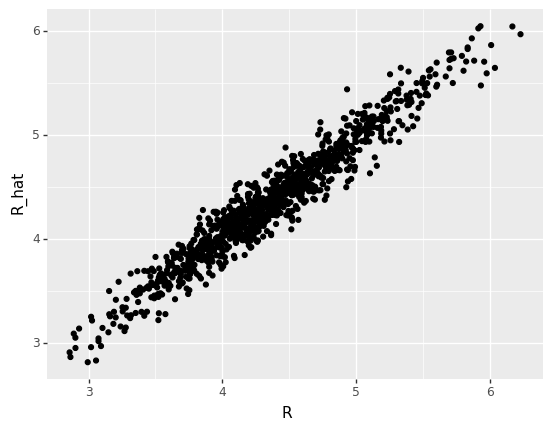

<ggplot: (8793749573637)>

In [9]:
from plotnine import ggplot, aes, geom_point,geom_line
ggplot(teams) + aes(x="R", y="R_hat") + geom_point()



So instead of using batting average, or just number of HR, as a measure of picking players, we can use our fitted model to form a metric that relates more directly to run production. Specifically, to define a metric for player A, we imagine a team made up of players just like player A and use our fitted regression model to predict how many runs this team would produce. The formula would look like this: 



To define a player-specific metric, we have a bit more work to do. A challenge here is that we derived the metric for teams, based on team-level summary statistics. For example, the HR value that is entered into the equation is HR per game for the entire team. If we compute the HR per game for a player, it will be much lower since the total is accumulated by 9 batters. Furthermore, if a player only plays part of the game and gets fewer opportunities than average, it is still considered a game played. For players, a rate that takes into account opportunities is the per-plate-appearance rate. 

To make the per-game team rate comparable to the per-plate-appearance player rate, we compute the average number of team plate appearances per game:

In [ ]:
batting=pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/Batting.csv")


In [ ]:
def extract_pa_per_game(df):
    
    pa_per_game = (df['AB'].sum() + df["BB"].sum())/df["G"].max()
    
    return pa_per_game


In [ ]:
pa_per_game=batting[batting.yearID ==2002].groupby('teamID').apply(extract_pa_per_game)
average_pa_teamwise = pa_per_game.mean()

We compute the per-plate-appearance rates for players available in 2002 on data from 1997-2001. To avoid small sample artifacts, we filter players with less than 200 plate appearances per year. Here is the entire calculation in one line:

In [ ]:
batting["PA"] = batting["AB"] + batting["BB"]
batting["singles"] = batting["H"] - batting["X2B"] - batting["X3B"] - batting["HR"]

players = batting[(batting.yearID >= 1997) & (batting.yearID <=2001)].groupby('playerID').agg(PA_sum = ("PA",sum),HR_sum=("HR",sum),BB_sum=("BB",sum),singles_sum=("singles",sum),doubles_sum=("X2B",sum),triples_sum=("X3B",sum),AB_sum=("AB",sum),H_sum=("H",sum))
players["Average_PA"] = players["PA_sum"]/average_pa_teamwise
players["HR"] = players["HR_sum"]/players["Average_PA"]
players["BB"] = players["BB_sum"]/players["Average_PA"]
players["singles"] = players["singles_sum"]/players["Average_PA"]
players["doubles"] = players["doubles_sum"]/players['Average_PA']
players["triples"] = players["triples_sum"]/players["Average_PA"]
players["Average"] = players["H_sum"]/players["AB_sum"]
players = players[players.PA_sum >= 1000]

In [ ]:
players_features = players[["HR","BB","singles","doubles","triples"]]
players_features.head()

,HR,BB,singles,doubles,triples
playerID,,,,,
abreubo01,1.321375,5.781016,6.111359,2.257349,0.454223
agbaybe01,1.279368,4.496064,6.287179,1.864222,0.219320
alfoned01,1.214388,4.541305,6.767683,1.998680,0.088549
alicelu01,0.475905,4.283142,6.722153,1.626007,0.436246
alomaro01,1.141080,4.288455,7.310437,2.169306,0.250787


In [ ]:
#players_features["R_hat"]=(reg.predict(players_features))
players_features["R_hat"]=(reg.predict(players_features))
players_features.head()

,HR,BB,singles,doubles,triples,R_hat
playerID,,,,,,
abreubo01,1.321375,5.781016,6.111359,2.257349,0.454223,8.657520
agbaybe01,1.279368,4.496064,6.287179,1.864222,0.219320,7.404873
alfoned01,1.214388,4.541305,6.767683,1.998680,0.088549,7.820334
alicelu01,0.475905,4.283142,6.722153,1.626007,0.436246,7.237259
alomaro01,1.141080,4.288455,7.310437,2.169306,0.250787,8.442398


In [ ]:
master = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/master.csv")
players_features  =  pd.merge(master[["playerID","nameFirst","nameLast"]],players_features,on="playerID")
players_features.head()

,playerID,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat
0,abreubo01,Bobby,Abreu,1.321375,5.781016,6.111359,2.257349,0.454223,8.657520
1,agbaybe01,Benny,Agbayani,1.279368,4.496064,6.287179,1.864222,0.219320,7.404873
2,alfoned01,Edgardo,Alfonzo,1.214388,4.541305,6.767683,1.998680,0.088549,7.820334
3,alicelu01,Luis,Alicea,0.475905,4.283142,6.722153,1.626007,0.436246,7.237259
4,alomaro01,Roberto,Alomar,1.141080,4.288455,7.310437,2.169306,0.250787,8.442398


The player-specific predicted runs computed here can be interpreted as the number of runs we predict a team will score if all batters are exactly like that player. The distribution shows that there is wide variability across players:

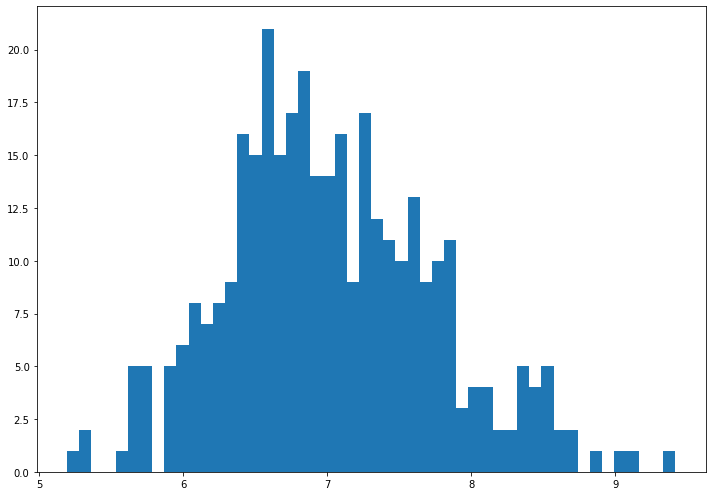

In [ ]:
n_bins = 50
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7), 
                        tight_layout = True)
#plt.hist(x=players_features["R_hat"])  
hist_df=axs.hist(x=players_features["R_hat"], bins = n_bins)

### Adding salary and position information

To actually build the team, we will need to know their salaries as well as their defensive position. For this, we join the **players** data frame we just created with the player information data frame included in some of the other Lahman data tables. We will learn more about the join function we learned in Section \@ref(joins). 

Start by adding the 2002 salary of each player:

In [ ]:
Salaries=pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/salaries.csv")
salaries_yr_2002 =Salaries[Salaries.yearID==2002]
salaries_yr_2002= salaries_yr_2002[["playerID","salary"]]

In [ ]:
player_insights = pd.merge(salaries_yr_2002, players_features, on='playerID')
player_insights.head()

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat
0,anderga01,5000000,Garret,Anderson,1.245384,1.676031,7.251160,2.234707,0.197865,7.110501
1,erstada01,6250000,Darin,Erstad,0.982139,3.197939,7.198358,2.024164,0.227569,7.529027
2,fabrejo01,500000,Jorge,Fabregas,0.583429,2.230759,6.623638,1.132539,0.171597,5.277921
3,fullmbr01,4000000,Brad,Fullmer,1.433642,2.504095,5.906606,2.676132,0.133807,7.061380
4,glaustr01,4000000,Troy,Glaus,2.105016,5.440932,4.299228,2.015821,0.053517,6.703095


In [ ]:
player_insights = player_insights.sort_values(by=['R_hat'], ascending=False)
player_insights.head()

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat
90,walkela01,12666667,Larry,Walker,2.326584,4.876878,6.845525,2.595036,0.313194,9.415283
222,martied01,7086668,Edgar,Martinez,1.741558,6.311602,6.410414,2.309725,0.049406,9.009369
87,heltoto01,5000000,Todd,Helton,2.240350,4.739202,6.218408,2.742993,0.157973,8.867603
174,willibe02,12357143,Bernie,Williams,1.614440,4.994675,6.937048,2.118953,0.290095,8.670962
194,abreubo01,6333333,Bobby,Abreu,1.321375,5.781016,6.111359,2.257349,0.454223,8.657520


We can see from the above dataframe that there are players whose salary is less but have a better estimate of predicted runs.

Next, we add their defensive position. This is a somewhat complicated task because players play more than one position each year.  However, because some players are traded, they appear more than once on the table, so we first sum their appearances across teams.
We also remove the **OF** position which stands for outfielder, a generalization of three positions: left field (LF), center field (CF), and right field (RF). We also remove pitchers since they don't bat in the league in which the A's play.

In [ ]:
appearances = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/appearances.csv")

In [ ]:
append_str = 'G_'
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
position_names = [append_str + sub for sub in position_names]

In [ ]:
operations_dict = {}
for term in position_names:
    operations_dict[term] = "sum"

In [ ]:
result = appearances[appearances.yearID == 2002].groupby("playerID").agg(operations_dict)

In [ ]:
result.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh
playerID,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0
abernbr01,0,0,0,116,0,0,0,0,0,1.0
abreubo01,0,0,0,0,0,0,0,18,148,0.0
acevejo01,6,0,0,0,0,0,0,0,0,0.0
aceveju01,65,0,0,0,0,0,0,0,0,0.0


In [ ]:
def max_position(x):
    
    position_counts = [x[term] for term in position_names]
    return position_counts.index(max(position_counts))

In [ ]:
result["most_played_position"] = result.apply(lambda x : position_names[max_position(x)][2:],axis=1)
result.head()


,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,most_played_position
playerID,,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0,p
abernbr01,0,0,0,116,0,0,0,0,0,1.0,2b
abreubo01,0,0,0,0,0,0,0,18,148,0.0,rf
acevejo01,6,0,0,0,0,0,0,0,0,0.0,p
aceveju01,65,0,0,0,0,0,0,0,0,0.0,p


In [ ]:
player_salary_position = pd.merge(player_insights, result, on='playerID')
player_salary_position.drop(position_names,axis=1,inplace=True)
player_salary_position = player_salary_position[player_salary_position["most_played_position"]!="p"]

In [ ]:
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
for position in position_names:
    player_salary_position["chronicle_delta_" + str(position)] = player_salary_position.apply(lambda x : 1 if x.most_played_position == position else 0,axis=1)

### Picking nine players

On average, players with a higher metric have higher salaries

-->
We can search for good deals by looking at players who produce many more runs than others with similar salaries. We can use this table to decide what players to pick and keep our total salary below the 40 million dollars Billy Beane had to work with. This can be done using what computer scientists call linear programming. This is not something we teach, but here are the position players selected with this approach:





In [ ]:
from mip import Model, xsum, maximize, BINARY

In [ ]:
## Here p denotes predicted runs. p[i] denote the runs for the ith player.
## Here w denotes the salary. w[i] denotes the salary for the ith player.
## chronicle_delta_position column of the dataframe denotes whether the player plays on that corresponding position or not.
p = player_salary_position["R_hat"]
w = player_salary_position["salary"]

c, I = 40000000, range(len(w))

In [ ]:
m = Model("knapsack")

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c


for position in position_names:
    m += xsum(player_salary_position["chronicle_delta_" + str(position)][i]*x[i] for i in I) == 1
    


m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))


selected items: [39, 73, 84, 103, 108, 121, 191, 217, 218]


In [ ]:
player_salary_position.drop(["chronicle_delta_" + str(position) for position in position_names],axis=1,inplace=True)
columns_to_be_rounded = ["HR","BB","singles","doubles","triples",]
for column in columns_to_be_rounded:
    player_salary_position[column] = round(player_salary_position[column],1)
player_salary_position["most_played_position"] = player_salary_position["most_played_position"].apply(lambda x :x.upper())
selected_team=player_salary_position.iloc[selected]
selected_team

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat,most_played_position
39,garcino01,9000000,Nomar,Garciaparra,1.7,2.8,7.3,2.6,0.4,8.561981,SS
73,walketo04,2050000,Todd,Walker,0.8,3.3,7.0,2.3,0.2,7.703161,2B
84,heltoto01,5000000,Todd,Helton,2.2,4.7,6.2,2.7,0.2,8.867603,1B
103,millake01,900000,Kevin,Millar,1.4,3.8,6.1,2.3,0.4,7.634930,LF
108,berkmla01,500000,Lance,Berkman,1.9,5.2,5.5,2.8,0.2,8.548005,CF
121,maynebr01,2500000,Brent,Mayne,0.4,3.9,7.6,2.1,0.0,7.886146,C
191,abreubo01,6333333,Bobby,Abreu,1.3,5.8,6.1,2.3,0.5,8.657520,RF
217,cirilje01,6375000,Jeff,Cirillo,0.8,3.9,7.8,2.3,0.1,8.484743,3B
218,martied01,7086668,Edgar,Martinez,1.7,6.3,6.4,2.3,0.0,9.009369,DH


We see that all these players have above average BB and most have above average HR rates, while the same is not true for singles. Here is a table with statistics standardized across players so that, for example, above average HR hitters have values above 0.







The same pattern arises when we look at the top performers: batting averages go down for most of the top performers.



But these are not rookies! Also, look at what happens to the worst performers of 2013:



Their batting averages mostly go up! Is this some sort of reverse sophomore slump? It is not. There is no such thing as the sophomore slump. This is all explained with a simple statistical fact: the correlation for performance in two separate years is high, but not perfect:



The correlation is **r cor(two_years$"2013",two_years$"2014")** and
the data look very much like a bivariate normal distribution, which means we predict a 2014 batting average $Y$ for any given player that had a 2013 batting average $X$ with:

$$ \frac{Y - .255}{.032} = 0.46 \left( \frac{X - .261}{.023}\right) $$

Because the correlation is not perfect, regression tells us that, on average, expect high performers from 2013 to do a bit worse in 2014. It's not a jinx; it's just due to chance. The ROY are selected from the top values of $X$ so it is expected that $Y$ will regress to the mean.


